# Master Informatique, parcours Data Mining

### Carnets de note Python pour le cours de Text Mining

Julien Velcin, laboratoire ERIC, Université Lyon 2

# Visualisation (partie 1)

In [2]:
import os

with open(os.path.join("Frank Herbert - Children of Dune.txt")) as f:
    lines = [line.strip() for line in f.readlines()]

## nuage de mots

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english")
vectorizer.fit(lines)
X = vectorizer.transform(lines)
X = X.toarray()
features = vectorizer.get_feature_names()

(num_doc, num_f) = X.shape

In [20]:
# les "labels" du nuage sont les mots
cloud_labels = features
# les poids correspondent à la somme des TF selon les lignes de la matrice
cloud_weights = np.sum(X, axis=0)
# on construit un dictionnaire qui associe chaque label (mot) au poids correspondant (TF total)
dictionary = dict(zip(cloud_labels, cloud_weights)) # zip "colle" le vecteur des labels au vecteur des poids
# on trie par ordre décroissant
sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True)

print(sorted_by_value[0:50])

[('said', 2271), ('paul', 1722), ('jessica', 901), ('thought', 620), ('baron', 593), ('duke', 576), ('man', 516), ('fremen', 514), ('hawat', 429), ('ll', 422), ('ve', 418), ('mother', 406), ('stilgar', 401), ('asked', 376), ('water', 374), ('kynes', 365), ('know', 363), ('gurney', 348), ('way', 347), ('eyes', 341), ('saw', 341), ('like', 336), ('hand', 333), ('arrakis', 329), ('voice', 322), ('time', 321), ('sand', 302), ('men', 301), ('emperor', 275), ('looked', 274), ('face', 264), ('old', 260), ('chani', 259), ('felt', 255), ('turned', 251), ('desert', 234), ('father', 234), ('feyd', 232), ('people', 231), ('spice', 230), ('leto', 227), ('came', 223), ('place', 212), ('thing', 211), ('halleck', 210), ('away', 209), ('harkonnen', 205), ('rautha', 202), ('dib', 200), ('muad', 200)]


In [21]:
from wordcloud import WordCloud

limit = 50
fontcolor='#fafafa'
bgcolor = '#000000'

wordcloud = WordCloud(
    max_words=limit,
    background_color=bgcolor,
).fit_words(dictionary) # cette fois, on donne au générateur le dictionnaire construit par nos soins   

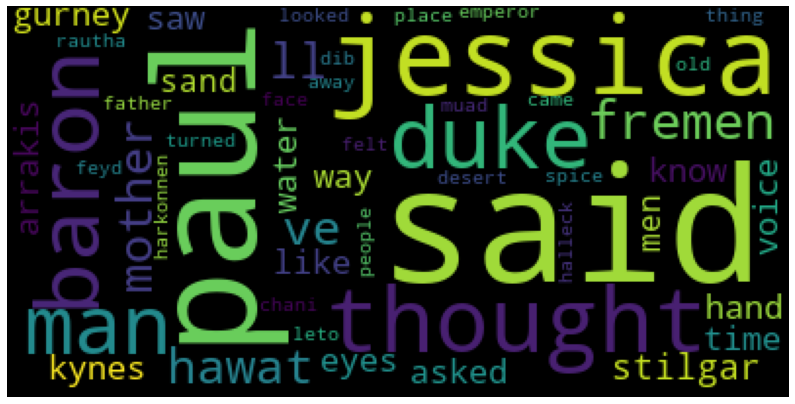

In [22]:
import random
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

title = "Nuage de mots pour Les Rois Maudits"

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## étude des co-occurrences

Il s'agit à présent d'étudier la co-occurrences de mots (sont-ils souvent employés ensemble ?).

Pour commencer, on va réduire la taille du vocabulaire pour ne garder que les mots les plus employés.

In [23]:
t_freq = np.where(cloud_weights>20)
index = t_freq[0]
X_small = X[:,index]
features_small = np.array(features)[index]
print(X_small.shape)

(_,num_f_small) = X_small.shape

print("Nombre de colonnes = mots : " + str(num_f_small))

(8608, 845)
Nombre de colonnes = mots : 845


In [31]:
np.array(features)[index][0:50]

array(['10', 'accept', 'accepted', 'action', 'agreed', 'ah', 'ahead',
       'air', 'al', 'alia', 'alive', 'ancient', 'anger', 'angry',
       'animal', 'answer', 'appear', 'appeared', 'area', 'arena', 'arm',
       'arms', 'arrakeen', 'arrakis', 'aside', 'ask', 'asked', 'atreides',
       'attack', 'attention', 'aware', 'awareness', 'away', 'bad',
       'baliset', 'banker', 'barked', 'baron', 'barrier', 'basin',
       'battle', 'bed', 'began', 'begin', 'beginning', 'believe', 'bene',
       'beneath', 'bent', 'best'], dtype='<U18')

Une manière "simple" consiste à multiplier la matrice de données par elle-même, ce qui revient à estimer une similarité entre les mots.

In [25]:
co_occ = np.matmul(X_small.transpose(), X_small)

In [30]:
id_mot = np.where(features_small == "spice")[0][0]
scores_coocc = co_occ[id_mot,:]
dico_co_occ = dict(zip(features_small, scores_coocc))
mots_coocc = sorted(dico_co_occ.items(), key=lambda kv: kv[1], reverse=True)
print(mots_coocc[0:20])

[('spice', 310), ('said', 74), ('paul', 51), ('arrakis', 48), ('guild', 37), ('water', 34), ('sand', 33), ('kynes', 29), ('mass', 28), ('fremen', 27), ('change', 22), ('men', 22), ('life', 21), ('like', 20), ('melange', 20), ('ll', 19), ('worm', 19), ('ve', 18), ('deep', 17), ('factory', 17)]


Ensuite, pour les besoins de la visualisation on a besoin de créer trois listes :
    
- ($mot_1$, $mot_1$, $mot_2$, $mot_3$...) : liste des mots "sources"
- ($mot_2$, $mot_7$, $mot_7$, $mot_1$...) : liste des mots "cibles
- ($co_{1_2}$, $co_{1_7}$, $co_{2_7}$, $co_{3_1}$...) : score de co-occurrence entre mots "sources" et "cible"

In [27]:
sources = []
targets = []
weights = []
for i in range(num_f_small):
    for j in range(num_f_small):
        if ((i != j) & (co_occ[i, j] > 20)):
                sources = sources + [features_small[i]]
                targets = targets + [features_small[j]]
                weights = weights + [float(co_occ[i, j])]
                # float tranforme la valeur de co-occurrence en un nombre réel
                # (nécessaire sous certains environnements)

In [28]:
import pandas as pd
# on crée des séries de données au format "pandas"
sources = pd.Series(sources)
targets = pd.Series(targets)
weights = pd.Series(weights)

La visualisation choisie utilise la librarie "Network" permettant de visualiser des graphes.

In [29]:
# cf. https://pyvis.readthedocs.io/en/latest/tutorial.html#networkx-integration

from pyvis.network import Network

net = Network(height="400px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

# set the physics layout of the network
net.barnes_hut()

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    net.add_node(src, src, title=src)
    net.add_node(dst, dst, title=dst)
    net.add_edge(src, dst, value=w)

neighbor_map = net.get_adj_list()

# add neighbor data to node hover data
for node in net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

net.show_buttons(filter_=['physics'])    
   
net.show("co-occurrences.html")

<img src="img/visu_co-occ.png" style='height: 400px'/>